In [29]:
###GSA Inventiory tackle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns

import pyspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

In [41]:
##Without merging test 07/21/2023 1:55 pm
solution_finder_data = pd.read_csv("C:/Users/dkim.CENSEO/Downloads/solution_finder_data_grouped.csv")
print(solution_finder_data.shape)
solution_finder_data = solution_finder_data.rename(columns={'  "Title"': 'Solution Name',
                                                            'CAS Agency': 'Managing Agency'})
#solution_finder_data['Managing Agency'] = solution_finder_data['Managing Agency'].str.split(',').str[1].str.strip()
#solution_finder_data['Spend Under Management Tier'] = solution_finder_data['Spend Under Management Tier'].str.strip().str.lower().str.replace('-', ' ').str.replace(' ', '_')

#replace_dict = {'sum_tier_2___multi_agency_solutions_&_agency_wide_best_in_class_solutions,tier_2___gov_wide,spend_under_management_tier_2___gov_wide': 'tier_2', 'tier_0____contracts_not_aligned_to_category_management_principles,tier_0___non_sum_contracts,spend_under_management_tier_0': 'tier_0', 'sum_tier_1__agency_wide_mandatory_solutions,tier_1___agency_wide,spend_under_management_tier_1___agency_wide': 'tier_1', 'sum_tier_1___small_business_agency_small_business_strategic_solutions,tier_1___sb,spend_under_management_tier_1___small_business': 'tier_1___sb', 'sum_tier_3___government_wide_best_in_class_solutions,tier_3___bic,spend_under_management_tier_3___best_in_class': 'bic', 'nan':'excluded' }
#solution_finder_data['Spend Under Management Tier'] = solution_finder_data['Spend Under Management Tier'].replace(replace_dict)



(255, 4)


In [42]:
contract_inventory_testing = pd.read_csv("C:/Users/dkim.CENSEO/Downloads/contract_inventory_data_grouped.csv")
# contract_inventory_testing['Spend Under Management Tier'] = contract_inventory_testing['Spend Under Management Tier'].str.strip().str.lower().str.replace('-', ' ').str.replace(' ', '_')


In [43]:
####Fixing the Managing Agency name
replace_dict = {'Department of Defense--Military Programs': 'DOD', 'Department of Justice': 'DOJ'}

solution_finder_data['Managing Agency'] = solution_finder_data['Managing Agency'].replace(replace_dict)


In [44]:
solution_finder_data['Managing Agency'].unique()

array(['DHHS', 'DHS', 'DI', 'DOD', 'DOJ', 'DVA', 'EPA', 'GSA'],
      dtype=object)

In [45]:
contract_inventory_testing['Managing Agency'].unique()

array(['ARMY', 'DAF', 'DHA', 'DHS', 'DLA', 'DOC', 'DOD', 'DOE', 'DOI',
       'DOJ', 'DOL', 'DOT', 'ED', 'EPA', 'GSA', 'HHS', 'HUD', 'LOC',
       'NASA', 'NAVY', 'NIH', 'NRC', 'NSF', 'OPM', 'OSD', 'SSA', 'STATE',
       'TREASURY', 'USACE', 'USAID', 'VA'], dtype=object)

In [46]:
##For contract inventory managing agency lets create a second one column where the managing agency is mixed together by the bigger agency
contract_inventory_testing['Managing Agency modified'] = contract_inventory_testing['Managing Agency']

replace_dict = {'ARMY': 'DOD', 'NAVY':'DOD', 'USACE':'DOD','DAF':'DOD','DHA':'DOD','DLA':'DOD', 'HHS': 'DHHS','NIH':'DHHS','OSD':'DOD','VA':'DVA'}
contract_inventory_testing['Managing Agency modified'] = contract_inventory_testing['Managing Agency modified'].replace(replace_dict)

In [47]:
contract_inventory_testing

,Unnamed: 0,Managing Agency,Solution Name,counts,Managing Agency modified
0,0,ARMY,AMCOM Expedited Professional & Engineering Sup...,6,DOD
1,1,ARMY,ARMY HR SOLUTIONS,113,DOD
2,2,ARMY,ARMYAF WIRELESS/NEXT GENERATION WIRELESS (NEXG...,7190,DOD
3,3,ARMY,AZD7442 Production (SARS-COV-2 Combination Ant...,1,DOD
4,4,ARMY,Administrative Services,1,DOD
...,...,...,...,...,...
4020,4020,VA,VHA,4,DVA
4021,4021,VA,VHA Office of Dentistry,2,DVA
4022,4022,VA,VITRIA BUSINESSWARE PROGRAMMING SUPPORT SERVICES,1,DVA
4023,4023,VA,Veterans Health Administration,1,DVA


In [105]:
###Fuzzy matching
from thefuzz import fuzz
def fuzzy_match(row):
    data_sub = solution_finder_data[solution_finder_data['Managing Agency'] == row['Managing Agency']]
    
    if data_sub.shape[0] == 0:
        return (0, "")
    
    token_set_ratio = (data_sub['Solution Name']
                       .apply(lambda y: fuzz.token_set_ratio(row['Solution Name'], y)) )
    
    # Create a boolean list in which the highest score is selected
    max_row         = (token_set_ratio == token_set_ratio.max())
    
    # Return the highest score and the highest solution name
    return token_set_ratio[max_row].iloc[0], data_sub.loc[max_row, 'Solution Name'].iloc[0]

# Return the highest score and highest solution name as a list
x = contract_inventory_testing.apply(fuzzy_match, 1)

# Map the first item in the list to a new column "Similarity Score"
contract_inventory_testing['Similarity Score'] = [v[0] for v in x]

# Map the second item in the list to a new column "Solution Map"
contract_inventory_testing['Solution Map']     = [v[1] for v in x]

In [25]:
###Fuzzy matching #in this verison we aren't matching by agency but by contract name only (result: may have to use the managing agency filter)
from thefuzz import fuzz
def fuzzy_match(row): #result: Its better when we modified the managing agency before hand, however we need to look over the gsa contract
    data_sub = solution_finder_data[solution_finder_data['Managing Agency'] == row['Managing Agency modified']]
    
    if data_sub.shape[0] == 0:
        return (0, "","") #return a tuple with three elements
    
    token_set_ratio = (data_sub['Solution Name']
                       .apply(lambda y: fuzz.token_set_ratio(row['Solution Name'], y)) )
    
    # Create a boolean list in which the highest score is selected
    max_row         = (token_set_ratio == token_set_ratio.max())
    
    # Return the highest score and the highest solution name
    #return token_set_ratio[max_row].iloc[0], solution_finder_data.loc[max_row, 'Solution Name'].iloc[0] #original
    return token_set_ratio[max_row].iloc[0], data_sub.loc[max_row, 'Solution Name'].iloc[0], data_sub.loc[max_row, 'Managing Agency'].iloc[0]

# Return the highest score and highest solution name as a list
x = contract_inventory_testing.apply(fuzzy_match, 1)

# Map the first item in the list to a new column "Similarity Score"
contract_inventory_testing['Similarity Score'] = [v[0] for v in x]

# Map the second item in the list to a new column "Solution Map"
contract_inventory_testing['Solution Map']     = [v[1] for v in x]

# Map the third item in the list to a new column "Solution agency"
contract_inventory_testing['Solution Agency']     = [v[2] for v in x] #extra line, unknown 

In [26]:
contract_inventory_testing[contract_inventory_testing['Similarity Score'] > 0]

,Unnamed: 0,Managing Agency,Solution Name,counts,Managing Agency modified,Similarity Score,Solution Map,Solution Agency
0,0,ARMY,AMCOM Expedited Professional & Engineering Sup...,6,DOD,47,RS3: Responsive Strategic Sourcing for Services,DOD
1,1,ARMY,ARMY HR SOLUTIONS,113,DOD,32,RS3: Responsive Strategic Sourcing for Services,DOD
2,2,ARMY,ARMYAF WIRELESS/NEXT GENERATION WIRELESS (NEXG...,7190,DOD,33,RS3: Responsive Strategic Sourcing for Services,DOD
3,3,ARMY,AZD7442 Production (SARS-COV-2 Combination Ant...,1,DOD,33,RS3: Responsive Strategic Sourcing for Services,DOD
4,4,ARMY,Administrative Services,1,DOD,52,RS3: Responsive Strategic Sourcing for Services,DOD
...,...,...,...,...,...,...,...,...
4020,4020,VA,VHA,4,DVA,13,Pharmaceutical Prime Vendor,DVA
4021,4021,VA,VHA Office of Dentistry,2,DVA,34,Schedule 65 II C Dental Equipment & Supplies,DVA
4022,4022,VA,VITRIA BUSINESSWARE PROGRAMMING SUPPORT SERVICES,1,DVA,39,Pharmaceutical Repackaging Program,DVA
4023,4023,VA,Veterans Health Administration,1,DVA,39,Pharmaceutical Prime Vendor,DVA


In [27]:
contract_inventory_testing #definately need that managing agency filter

,Unnamed: 0,Managing Agency,Solution Name,counts,Managing Agency modified,Similarity Score,Solution Map,Solution Agency
0,0,ARMY,AMCOM Expedited Professional & Engineering Sup...,6,DOD,47,RS3: Responsive Strategic Sourcing for Services,DOD
1,1,ARMY,ARMY HR SOLUTIONS,113,DOD,32,RS3: Responsive Strategic Sourcing for Services,DOD
2,2,ARMY,ARMYAF WIRELESS/NEXT GENERATION WIRELESS (NEXG...,7190,DOD,33,RS3: Responsive Strategic Sourcing for Services,DOD
3,3,ARMY,AZD7442 Production (SARS-COV-2 Combination Ant...,1,DOD,33,RS3: Responsive Strategic Sourcing for Services,DOD
4,4,ARMY,Administrative Services,1,DOD,52,RS3: Responsive Strategic Sourcing for Services,DOD
...,...,...,...,...,...,...,...,...
4020,4020,VA,VHA,4,DVA,13,Pharmaceutical Prime Vendor,DVA
4021,4021,VA,VHA Office of Dentistry,2,DVA,34,Schedule 65 II C Dental Equipment & Supplies,DVA
4022,4022,VA,VITRIA BUSINESSWARE PROGRAMMING SUPPORT SERVICES,1,DVA,39,Pharmaceutical Repackaging Program,DVA
4023,4023,VA,Veterans Health Administration,1,DVA,39,Pharmaceutical Prime Vendor,DVA


In [28]:
contract_inventory_testing.to_csv("C:/Users/dkim.CENSEO/Downloads/fuzzy_matching_no_agency_test_2.csv")

In [38]:
managing_agency_counts = solution_finder_data['Managing Agency'].value_counts(normalize=True) * 100

# The result is a Series with the Managing Agency categories as the index and the percentages as the values
print(managing_agency_counts)

Managing Agency representation
GSA: 43%
EPA: 32%
DOJ: 9.8%
DHS: 9.4%
DVA: 2%
DHHS: 1.6%
DI: 0.39%
DOD: 0.39%

Managing Agency
GSA     43.529412
EPA     32.941176
DOJ      9.803922
DHS      9.411765
DVA      1.960784
DHHS     1.568627
DI       0.392157
DOD      0.392157
Name: proportion, dtype: float64


In [48]:
####In this new one lets focus only on GSA contracts from solution finders and ignore the rest. Contract Inventory has all of the contracts
solution_finder_data_GSA = solution_finder_data[solution_finder_data['Managing Agency'] == 'GSA']

solution_finder_data_GSA


,Unnamed: 0,Managing Agency,Solution Name,counts
144,144,GSA,18F,1
145,145,GSA,8(a) STARS III: Streamlined Technology Acquisi...,1
146,146,GSA,AIR Card,1
147,147,GSA,AbilityOne: Providing Products and Services So...,1
148,148,GSA,Administrative Resource Center (ARC) - Tempora...,1
...,...,...,...,...
250,250,GSA,VETS 2: Veterans Technology Services 2 (Best I...,1
251,251,GSA,VHA Healthcare Furniture IDIQs,1
252,252,GSA,Vehicle Telematics,1
253,253,GSA,WC MCMS II: Workersâ€™ Compensation Medical Ca...,1


In [49]:
###Fuzzy matching #in this verison we aren't matching by agency but by contract name only (result: may have to use the managing agency filter)
from thefuzz import fuzz
def fuzzy_match(row): #result: Its better when we modified the managing agency before hand, however we need to look over the gsa contract
#    data_sub = solution_finder_data_GSA[solution_finder_data_GSA['Managing Agency'] == row['Managing Agency modified']]
#    
#    if data_sub.shape[0] == 0:
#        return (0, "","") #return a tuple with three elements
    
    token_set_ratio = (solution_finder_data_GSA['Solution Name']
                       .apply(lambda y: fuzz.token_set_ratio(row['Solution Name'], y)) )
    
    # Create a boolean list in which the highest score is selected
    max_row         = (token_set_ratio == token_set_ratio.max())
    
    # Return the highest score and the highest solution name
    #return token_set_ratio[max_row].iloc[0], solution_finder_data.loc[max_row, 'Solution Name'].iloc[0] #original
    return token_set_ratio[max_row].iloc[0], solution_finder_data_GSA.loc[max_row, 'Solution Name'].iloc[0], solution_finder_data_GSA.loc[max_row, 'Managing Agency'].iloc[0]

# Return the highest score and highest solution name as a list
x = contract_inventory_testing.apply(fuzzy_match, 1)

# Map the first item in the list to a new column "Similarity Score"
contract_inventory_testing['Similarity Score'] = [v[0] for v in x]

# Map the second item in the list to a new column "Solution Map"
contract_inventory_testing['Solution Map']     = [v[1] for v in x]

# Map the third item in the list to a new column "Solution agency"
contract_inventory_testing['Solution Agency']     = [v[2] for v in x] #extra line, unknown 

In [51]:
contract_inventory_testing

,Unnamed: 0,Managing Agency,Solution Name,counts,Managing Agency modified,Similarity Score,Solution Map,Solution Agency
0,0,ARMY,AMCOM Expedited Professional & Engineering Sup...,6,DOD,97,EXPRESS: Expedited Professional and Engineerin...,GSA
1,1,ARMY,ARMY HR SOLUTIONS,113,DOD,83,HR Solutions - Department of Defense,GSA
2,2,ARMY,ARMYAF WIRELESS/NEXT GENERATION WIRELESS (NEXG...,7190,DOD,57,NGDS: Next Generation Delivery Service (Best I...,GSA
3,3,ARMY,AZD7442 Production (SARS-COV-2 Combination Ant...,1,DOD,53,"Reutilization, Transfer and Donation (R/T/D)",GSA
4,4,ARMY,Administrative Services,1,DOD,100,Administrative Resource Center (ARC) - Tempora...,GSA
...,...,...,...,...,...,...,...,...
4020,4020,VA,VHA,4,DVA,100,VHA Healthcare Furniture IDIQs,GSA
4021,4021,VA,VHA Office of Dentistry,2,DVA,43,Enterprise Software Solutions and Security,GSA
4022,4022,VA,VITRIA BUSINESSWARE PROGRAMMING SUPPORT SERVICES,1,DVA,58,Category Management Support Services (CMSS) BPA,GSA
4023,4023,VA,Veterans Health Administration,1,DVA,60,Reverse Distribution,GSA


In [52]:
contract_inventory_testing.to_csv("C:/Users/dkim.CENSEO/Downloads/gsa_only_fuzzymatch.csv")

In [55]:
###Summary stats for the metdadata (08/09/2023)
summary_stats = pd.read_csv("C:/Users/dkim.CENSEO/Downloads/20230803 Solutions Metadata.csv")
summary_stats

,Row ID,Managing Agency (Contract inventory),Contract Inventory Name,SF ID,Managing Agency (solution finder),Solutions Finder Name,Ambigious,Found in CI,Found in SF,URL (SF pathway),Notes,Proposed Name Change
0,1,DHS,12 Gauge 00 Buckshot Duty & Training Ammunition,66444.0,DHS,12 Gauge 00 Buckshot (Reduced Recoil) Duty Amm...,0.0,1,1,https://hallways.cap.gsa.gov/app/#/solutionsfi...,NaN,NaN
1,2,DHS,9mm Ammo,66442.0,DHS,9mm Duty Ammunition (147 Grain),0.0,1,1,https://hallways.cap.gsa.gov/app/#/solutionsfi...,NaN,9mm ammuition
2,3,DHS,9mm Duty Handgun,83724.0,DHS,9mm Duty Handgun,0.0,1,1,https://hallways.cap.gsa.gov/app/#/solutionsfi...,NaN,9mm Duty Handgun
3,4,DHS,9mm Readily Identifiable Training Ammunition (...,66440.0,DHS,9mm Readily Identifiable Training Ammunition (...,0.0,1,1,https://hallways.cap.gsa.gov/app/#/solutionsfi...,NaN,9mm Readily Identifiable Training Ammunition (...
4,5,DHS,DHS Ammunition MACs,66444.0,DHS,12 Gauge 00 Buckshot (Reduced Recoil) Duty Amm...,1.0,1,1,https://hallways.cap.gsa.gov/app/#/solutionsfi...,this is a Multi Agency Contract so they includ...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
4182,4183,NaN,NaN,7311.0,GSA,Special Operational Equipment Tailored Logisti...,NaN,0,1,https://hallways.cap.gsa.gov/app/#/solutionsfi...,NaN,NaN
4183,4184,NaN,NaN,7254.0,GSA,TDY Lodging (Best In Class),NaN,0,1,https://hallways.cap.gsa.gov/app/#/solutionsfi...,NaN,NaN
4184,4185,NaN,NaN,8977.0,GSA,U.S. GOVERNMENT RENTAL CAR PROGRAM (Best in Cl...,NaN,0,1,https://hallways.cap.gsa.gov/app/#/solutionsfi...,NaN,NaN
4185,4186,NaN,NaN,7385.0,GSA,USALearning (Best In Class),NaN,0,1,https://hallways.cap.gsa.gov/app/#/solutionsfi...,NaN,NaN


In [58]:
summary_stats.columns
summary_stats_only_matched = summary_stats[(summary_stats['Found in CI'] == 1) & (summary_stats['Found in SF'] == 1)]
summary_stats_only_matched



,Row ID,Managing Agency (Contract inventory),Contract Inventory Name,SF ID,Managing Agency (solution finder),Solutions Finder Name,Ambigious,Found in CI,Found in SF,URL (SF pathway),Notes,Proposed Name Change
0,1,DHS,12 Gauge 00 Buckshot Duty & Training Ammunition,66444.0,DHS,12 Gauge 00 Buckshot (Reduced Recoil) Duty Amm...,0.0,1,1,https://hallways.cap.gsa.gov/app/#/solutionsfi...,NaN,NaN
1,2,DHS,9mm Ammo,66442.0,DHS,9mm Duty Ammunition (147 Grain),0.0,1,1,https://hallways.cap.gsa.gov/app/#/solutionsfi...,NaN,9mm ammuition
2,3,DHS,9mm Duty Handgun,83724.0,DHS,9mm Duty Handgun,0.0,1,1,https://hallways.cap.gsa.gov/app/#/solutionsfi...,NaN,9mm Duty Handgun
3,4,DHS,9mm Readily Identifiable Training Ammunition (...,66440.0,DHS,9mm Readily Identifiable Training Ammunition (...,0.0,1,1,https://hallways.cap.gsa.gov/app/#/solutionsfi...,NaN,9mm Readily Identifiable Training Ammunition (...
4,5,DHS,DHS Ammunition MACs,66444.0,DHS,12 Gauge 00 Buckshot (Reduced Recoil) Duty Amm...,1.0,1,1,https://hallways.cap.gsa.gov/app/#/solutionsfi...,this is a Multi Agency Contract so they includ...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
268,269,GSA,SCHEDULE 70 ESRI,7152.0,GSA,ESRI: Environmental Systems Research Institute...,2.0,1,1,https://hallways.cap.gsa.gov/app/#/solutionsfi...,NaN,NaN
269,270,GSA,MEDICAL LABORATORY TESTING AND ANALYSIS SERVICES,7321.0,GSA,Schedule 621 II: Medical Laboratory Testing & ...,1.0,1,1,https://hallways.cap.gsa.gov/app/#/solutionsfi...,NaN,NaN
270,271,VA,MEDICAL LABORATORY TESTING AND ANALYSIS SERVICES,7321.0,GSA,Schedule 621 II: Medical Laboratory Testing & ...,2.0,1,1,https://hallways.cap.gsa.gov/app/#/solutionsfi...,NaN,NaN
271,272,GSA,PROFESSIONAL AND ALLIED HEALTHCARE STAFFING SE...,7322.0,GSA,Schedule 621 I: Professional & Allied Healthca...,1.0,1,1,https://hallways.cap.gsa.gov/app/#/solutionsfi...,NaN,NaN


In [62]:
number_of_unique_values = summary_stats_only_matched['Contract Inventory Name'].nunique()

print(number_of_unique_values) #239 unique contract name or 5% of contract inventory data

239/4025


239


0.05937888198757764

In [61]:
number_of_unique_values = summary_stats_only_matched['Solutions Finder Name'].nunique()

print(number_of_unique_values) #109 unique contract name or 42% of solution finders

109/257


109


0.42412451361867703

In [92]:
unique_contracts_df

,Row ID,Managing Agency (Contract inventory),Contract Inventory Name,SF ID,Managing Agency (solution finder),Solutions Finder Name,Ambigious,Found in CI,Found in SF,URL (SF pathway),Notes,Proposed Name Change
0,1,DHS,12 Gauge 00 Buckshot Duty & Training Ammunition,66444.0,DHS,12 Gauge 00 Buckshot (Reduced Recoil) Duty Amm...,0.0,1,1,https://hallways.cap.gsa.gov/app/#/solutionsfi...,NaN,NaN
1,2,DHS,9mm Ammo,66442.0,DHS,9mm Duty Ammunition (147 Grain),0.0,1,1,https://hallways.cap.gsa.gov/app/#/solutionsfi...,NaN,9mm ammuition
2,3,DHS,9mm Duty Handgun,83724.0,DHS,9mm Duty Handgun,0.0,1,1,https://hallways.cap.gsa.gov/app/#/solutionsfi...,NaN,9mm Duty Handgun
3,4,DHS,9mm Readily Identifiable Training Ammunition (...,66440.0,DHS,9mm Readily Identifiable Training Ammunition (...,0.0,1,1,https://hallways.cap.gsa.gov/app/#/solutionsfi...,NaN,9mm Readily Identifiable Training Ammunition (...
4,5,DHS,DHS Ammunition MACs,66444.0,DHS,12 Gauge 00 Buckshot (Reduced Recoil) Duty Amm...,1.0,1,1,https://hallways.cap.gsa.gov/app/#/solutionsfi...,this is a Multi Agency Contract so they includ...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
268,269,GSA,SCHEDULE 70 ESRI,7152.0,GSA,ESRI: Environmental Systems Research Institute...,2.0,1,1,https://hallways.cap.gsa.gov/app/#/solutionsfi...,NaN,NaN
269,270,GSA,MEDICAL LABORATORY TESTING AND ANALYSIS SERVICES,7321.0,GSA,Schedule 621 II: Medical Laboratory Testing & ...,1.0,1,1,https://hallways.cap.gsa.gov/app/#/solutionsfi...,NaN,NaN
270,271,VA,MEDICAL LABORATORY TESTING AND ANALYSIS SERVICES,7321.0,GSA,Schedule 621 II: Medical Laboratory Testing & ...,2.0,1,1,https://hallways.cap.gsa.gov/app/#/solutionsfi...,NaN,NaN
271,272,GSA,PROFESSIONAL AND ALLIED HEALTHCARE STAFFING SE...,7322.0,GSA,Schedule 621 I: Professional & Allied Healthca...,1.0,1,1,https://hallways.cap.gsa.gov/app/#/solutionsfi...,NaN,NaN


Managing Agency (Contract inventory)
NAVY        20.078740
GSA         17.716535
DHS         16.535433
ARMY         7.480315
NASA         7.086614
VA           7.086614
DOJ          6.299213
DLA          5.511811
EPA          5.118110
NIH          1.968504
HHS          0.787402
DAF          0.787402
DOI          0.393701
OPM          0.393701
DOD          0.393701
DOT          0.393701
TREASURY     0.393701
OSD          0.393701
DOC          0.393701
DOL          0.393701
USACE        0.393701
Name: proportion, dtype: float64
Managing Agency (Contract inventory)
NAVY        51
GSA         45
DHS         42
ARMY        19
NASA        18
VA          18
DOJ         16
DLA         14
EPA         13
NIH          5
HHS          2
DAF          2
DOI          1
OPM          1
DOD          1
DOT          1
TREASURY     1
OSD          1
DOC          1
DOL          1
USACE        1
Name: count, dtype: int64


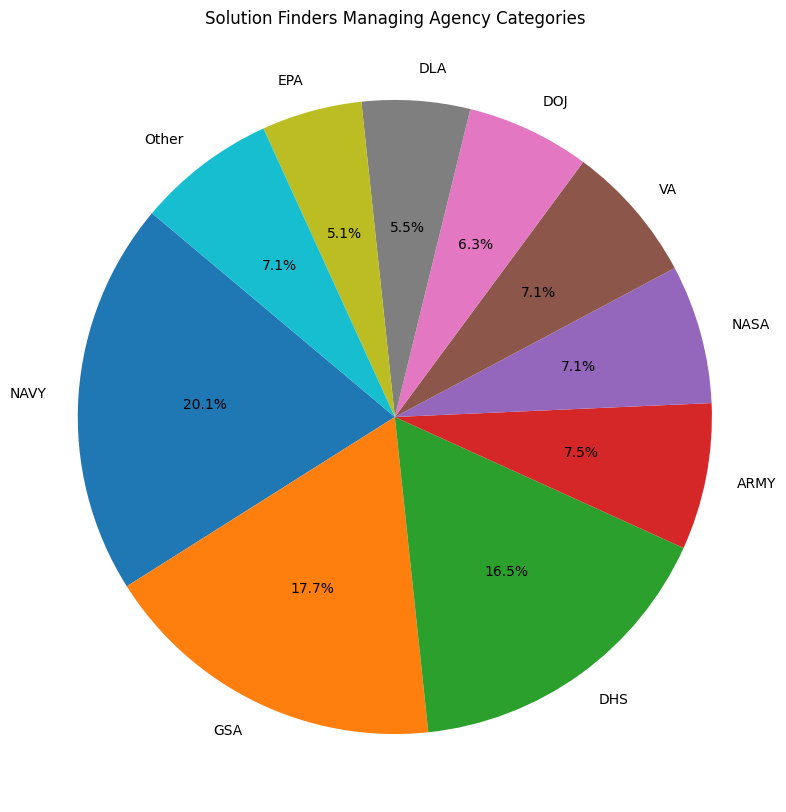

In [91]:
# Dropping duplicate rows based on the "Contract Inventory Name" column #This will find the number of unique contracts in contract inventory name 
unique_contracts_df = summary_stats_only_matched.drop_duplicates(subset=['Contract Inventory Name','Managing Agency (Contract inventory)'])

# Calculating the percentage distribution for the "Managing Agency (Contract inventory)" column
managing_agency_counts = unique_contracts_df['Managing Agency (Contract inventory)'].value_counts(normalize=True) * 100

# Printing the results
print(managing_agency_counts)

managing_agency_counts = unique_contracts_df['Managing Agency (Contract inventory)'].value_counts() 
print(managing_agency_counts)

import matplotlib.pyplot as plt

# Assuming managing_agency_counts is already created as shown in your code
managing_agency_counts = unique_contracts_df['Managing Agency (Contract inventory)'].value_counts(normalize=True) * 100

# Identify categories with less than 4% and combine them into "Other"
other_percentage = managing_agency_counts[managing_agency_counts < 4].sum()
managing_agency_counts = managing_agency_counts[managing_agency_counts >= 4]
managing_agency_counts['Other'] = other_percentage

# Creating a pie chart
plt.figure(figsize=(9, 10))
plt.pie(managing_agency_counts, labels=managing_agency_counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular
plt.title('Solution Finders Managing Agency Categories')
plt.show()

Managing Agency (solution finder)
GSA     62.385321
DHS     12.844037
EPA     11.926606
DOJ      6.422018
DVA      2.752294
DHHS     1.834862
DI       0.917431
DOD      0.917431
Name: proportion, dtype: float64
Managing Agency (solution finder)
GSA     68
DHS     14
EPA     13
DOJ      7
DVA      3
DHHS     2
DI       1
DOD      1
Name: count, dtype: int64


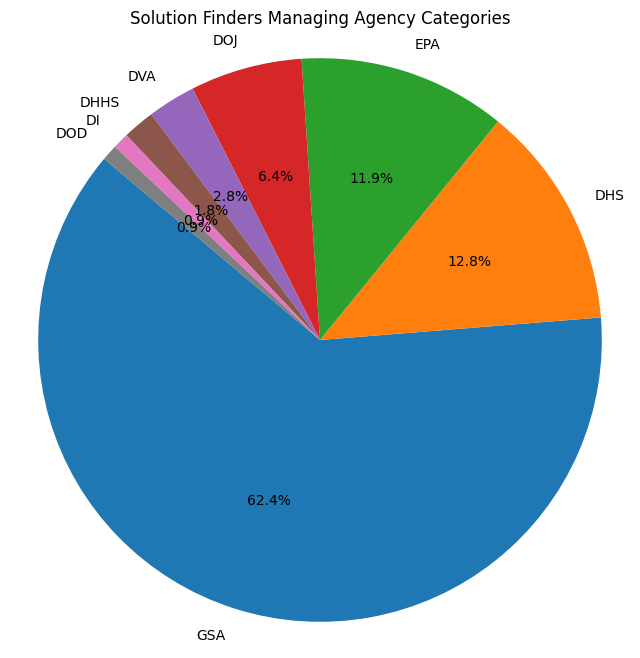

In [89]:
# Dropping duplicate rows based on the "Contract Inventory Name" column #correct one 08/09/2023 4:32 pm
unique_contracts_df = summary_stats_only_matched.drop_duplicates(subset=['Solutions Finder Name'])

# Calculating the percentage distribution for the "Managing Agency (Contract inventory)" column
managing_agency_counts = unique_contracts_df['Managing Agency (solution finder)'].value_counts(normalize=True) * 100

# Printing the results
print(managing_agency_counts)

managing_agency_counts = unique_contracts_df['Managing Agency (solution finder)'].value_counts() 
print(managing_agency_counts)

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming managing_agency_counts is already created as shown in your code
managing_agency_counts = unique_contracts_df['Managing Agency (solution finder)'].value_counts(normalize=True) * 100

# Creating a pie chart
plt.figure(figsize=(8, 8))
plt.pie(managing_agency_counts, labels=managing_agency_counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular
plt.title('Solution Finders Managing Agency Categories')
plt.show()

In [64]:
# Assuming solution_finder_data is already a DataFrame
managing_agency_counts = summary_stats_only_matched['Managing Agency (Contract inventory)'].value_counts(normalize=True) * 100

# The result is a Series with the Managing Agency categories as the index and the percentages as the values
print(managing_agency_counts)

Managing Agency (Contract inventory)
NAVY        19.702602
GSA         19.330855
DHS         17.100372
ARMY         7.063197
NASA         7.063197
VA           7.063197
DOJ          5.947955
DLA          5.204461
EPA          4.832714
NIH          1.858736
HHS          0.743494
DAF          0.743494
DOI          0.371747
OPM          0.371747
DOD          0.371747
DOT          0.371747
TREASURY     0.371747
OSD          0.371747
DOC          0.371747
DOL          0.371747
USACE        0.371747
Name: proportion, dtype: float64


In [79]:
# Assuming summary_stats_only_matched is already a DataFrame
managing_agency_counts = summary_stats_only_matched['Managing Agency (Contract inventory)'].value_counts()

# The result is a Series with the Managing Agency categories as the index and the counts as the values
print(managing_agency_counts)

Managing Agency (Contract inventory)
NAVY        53
GSA         52
DHS         46
ARMY        19
NASA        19
VA          19
DOJ         16
DLA         14
EPA         13
NIH          5
HHS          2
DAF          2
DOI          1
OPM          1
DOD          1
DOT          1
TREASURY     1
OSD          1
DOC          1
DOL          1
USACE        1
Name: count, dtype: int64


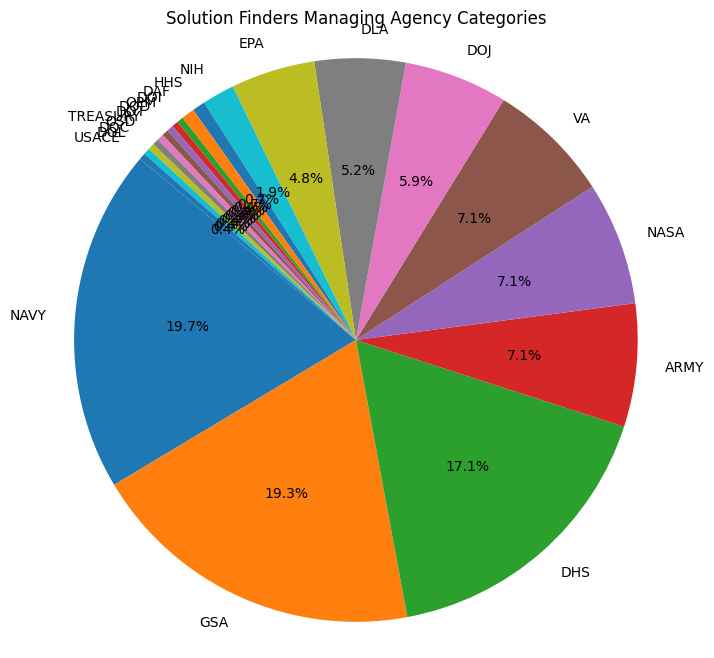

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming managing_agency_counts is already created as shown in your code
managing_agency_counts = summary_stats_only_matched['Managing Agency (Contract inventory)'].value_counts(normalize=True) * 100

# Creating a pie chart
plt.figure(figsize=(8, 8))
plt.pie(managing_agency_counts, labels=managing_agency_counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular
plt.title('Solution Finders Managing Agency Categories')
plt.show()

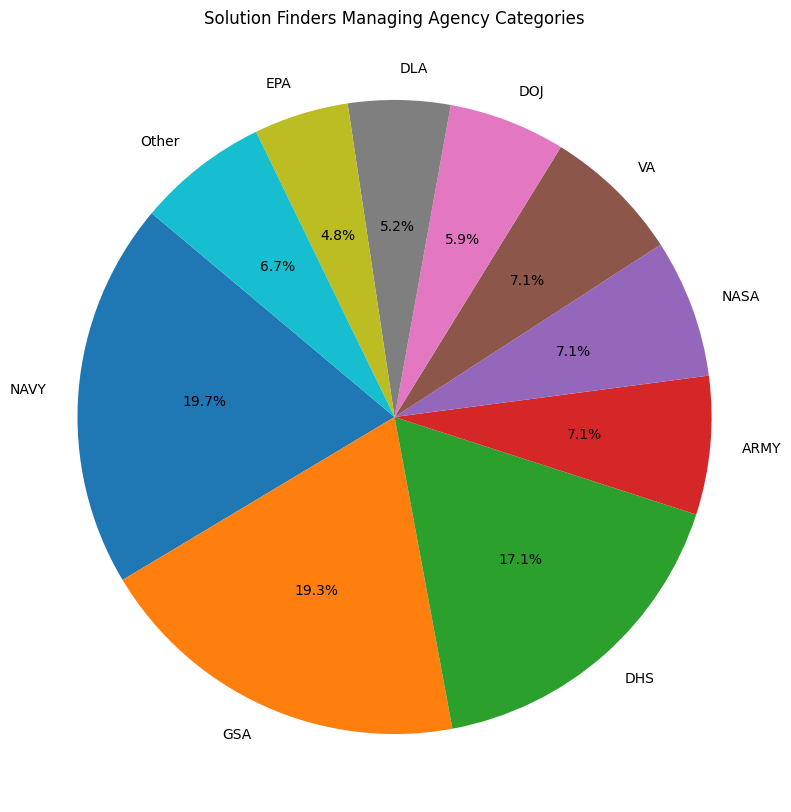

In [74]:
import matplotlib.pyplot as plt

# Assuming managing_agency_counts is already created as shown in your code
managing_agency_counts = summary_stats_only_matched['Managing Agency (Contract inventory)'].value_counts(normalize=True) * 100

# Identify categories with less than 4% and combine them into "Other"
other_percentage = managing_agency_counts[managing_agency_counts < 4].sum()
managing_agency_counts = managing_agency_counts[managing_agency_counts >= 4]
managing_agency_counts['Other'] = other_percentage

# Creating a pie chart
plt.figure(figsize=(9, 10))
plt.pie(managing_agency_counts, labels=managing_agency_counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular
plt.title('Solution Finders Managing Agency Categories')
plt.show()


In [65]:
# Assuming solution_finder_data is already a DataFrame
managing_agency_counts = summary_stats_only_matched['Managing Agency (solution finder)'].value_counts(normalize=True) * 100

# The result is a Series with the Managing Agency categories as the index and the percentages as the values
print(managing_agency_counts)

Managing Agency (solution finder)
GSA     76.579926
DHS     10.408922
EPA      4.832714
DOJ      4.460967
DHHS     1.858736
DVA      1.115242
DI       0.371747
DOD      0.371747
Name: proportion, dtype: float64


In [78]:
# Assuming summary_stats_only_matched is already a DataFrame
managing_agency_counts = summary_stats_only_matched['Managing Agency (solution finder)'].value_counts()

# The result is a Series with the Managing Agency categories as the index and the counts as the values
print(managing_agency_counts)


Managing Agency (solution finder)
GSA     206
DHS      28
EPA      13
DOJ      12
DHHS      5
DVA       3
DI        1
DOD       1
Name: count, dtype: int64


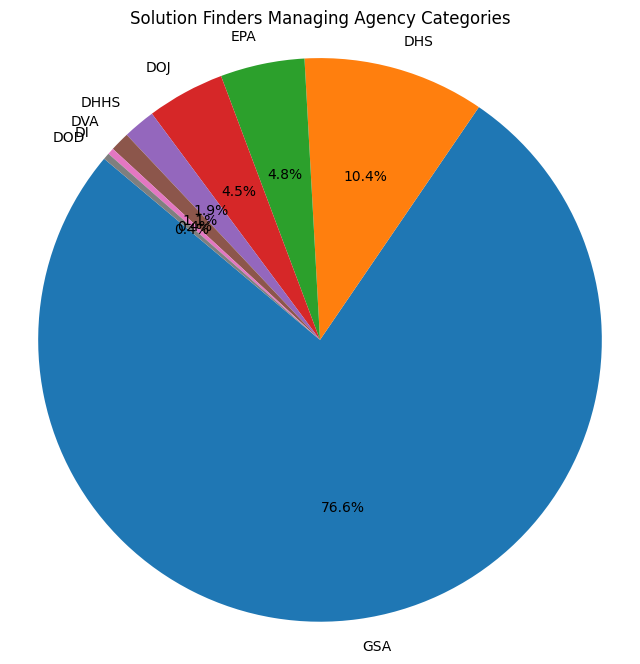

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming managing_agency_counts is already created as shown in your code
managing_agency_counts = summary_stats_only_matched['Managing Agency (solution finder)'].value_counts(normalize=True) * 100

# Creating a pie chart
plt.figure(figsize=(8, 8))
plt.pie(managing_agency_counts, labels=managing_agency_counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular
plt.title('Solution Finders Managing Agency Categories')
plt.show()


In [63]:
summary_stats_only_matched.columns

Index(['Row ID', 'Managing Agency (Contract inventory)',
       'Contract Inventory Name', 'SF ID', 'Managing Agency (solution finder)',
       'Solutions Finder Name', 'Ambigious', 'Found in CI', 'Found in SF',
       'URL (SF pathway)', 'Notes', 'Proposed Name Change'],
      dtype='object')

In [94]:
51+ 45+ 42+ 19+18+18+16+14+13+5+2+2+9
68+14+13+7+3+2+1+1

109